#Miljødataanalyse - Kode Del

In [39]:
import pandas as pd

# Read the CSV file
weather_data = pd.read_csv("../data/weather_data.csv")

# View the first 5 rows
weather_data.head()


,time,temperature,humidity,wind_speed_mps,cloud_cover,pressure
0,2025-04-21 10:00:00+00:00,9.4,63.0,2.2,92.6,1012.4
1,2025-04-21 11:00:00+00:00,10.2,60.0,2.2,94.0,1012.5
2,2025-04-21 12:00:00+00:00,11.1,58.0,2.3,94.8,1012.5
3,2025-04-21 13:00:00+00:00,11.7,55.0,1.9,95.5,1012.6
4,2025-04-21 14:00:00+00:00,12.4,53.0,1.8,98.7,1012.5


In [46]:
import requests
import pandas as pd
from pandasql import sqldf 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
"""
Jeg måtte kjøre pip install pandasql i en egen notebook-celle
 for å få det til å funke, det gikk ikke å bare installere i terminal. 
 Jeg slettet den etterpå, men om det ikke funker for dere kan dere prøve det.
"""

'\nJeg måtte kjøre pip install pandasql i en egen notebook-celle\n for å få det til å funke, det gikk ikke å bare installere i terminal. \n Jeg slettet den etterpå, men om det ikke funker for dere kan dere prøve det.\n'

In [ ]:
"""Oppgave 2 Datainnsamling"""
"""
Hentet fra: https://api.met.no/ mer spesifikt hentet jeg API-en fra:
 https://api.met.no/weatherapi/locationforecast/2.0/documentation
"""


url = "https://api.met.no/weatherapi/locationforecast/2.0/compact"
# Denne API krever user agent, står på nettsiden
headers = {
    "User-Agent": "Gruppe43"
    #"Id-Modified_Since": "2024-04-21"
    #Oppdater ID-midified since hver dag
}

params = {
    "lat": 63.4305,
    "lon": 10.3951
}

res = requests.get(url, headers=headers, params=params)
data = res.json()

timeseries = data["properties"]["timeseries"] #Gir en liste av værdata per time 

weather_data = [
    {
        "time": entry["time"],
        "temperature": entry["data"]["instant"]["details"].get("air_temperature"),
        "humidity": entry["data"]["instant"]["details"].get("relative_humidity"),
        "wind_speed": entry["data"]["instant"]["details"].get("wind_speed"),
        "cloud_cover": entry["data"]["instant"]["details"].get("cloud_area_fraction"),
        "pressure": entry["data"]["instant"]["details"].get("air_pressure_at_sea_level"),
    }
    for entry in timeseries  # loop gjennom værmeldingen for hver time
]

df = pd.DataFrame(weather_data) # Gjør om til pandas dataframe (Gjør det til en tabell)

#Bruke pandasql for å finne 10 varmeste tidene (Den sto i oppgaven vi måtte bruke pandasql så jeg bare la noe til, vi kan endre på det senere)
query = "SELECT time, temperature FROM df WHERE temperature IS NOT NULL ORDER BY temperature DESC LIMIT 10"
result = sqldf(query)
print(result)



                   time  temperature
0  2025-04-21T15:00:00Z         13.5
1  2025-04-21T16:00:00Z         13.4
2  2025-04-21T14:00:00Z         13.2
3  2025-04-21T17:00:00Z         13.1
4  2025-04-21T13:00:00Z         12.5
5  2025-04-29T18:00:00Z         12.3
6  2025-04-21T18:00:00Z         12.2
7  2025-04-28T18:00:00Z         12.0
8  2025-04-29T12:00:00Z         12.0
9  2025-04-21T12:00:00Z         11.9


In [ ]:
"""Oppgave 3 Databehandling"""

def vis_manglende_verdier(df):
    """Finner og viser manglende verdier"""
    print("Manglende verdier per kolonne:")
    print(df.isnull().sum()) #Viser antall manglende verdier per kolonne (Det er ingen mangler :( vi må lage mangler, men tror det skal gå fint

def rens_data(df):
    """Renser manglende og 'rare' verdier"""
    #Lager en kopi så vi ikke endrer originalen
    df = df.copy()

    #Dette er eksempler på data rensing som jeg fant på nett vi kan finpusse sammen

    #Fjerner rader der temperaturen mangler
    df = df.dropna(subset=["temperature"]) 

    #Fyller NaN temperatur verdier med medianen
    df["temperature"] = df["temperature"].fillna(df["temperature"].mean())

    #Gjør det samme men med fuktighetsverdier
    df["humidity"] = df["humidity"].fillna(df["humidity"].mean())

    #Fjerner fuktighets verdier som ikke går an (over 100 eller under 0)
    df = df[(df["humidity"] >= 0) & (df["humidity"] <= 100)]

    #Erstatt ekstreme temperaturer som ikke er mulig/ gir mening med NaN
    df.loc[df["temperature"] < -60, "temperature"] = pd.NA
    df.loc[df["temperature"] > 60, "temperature"] = pd.NA

    return df

def formater_data(df):
    """Formaterer dataene for å gjøre dem mer strukturert og leselig"""
    df = df.copy()

    #Gjør tid kolonnen om til datetime
    df["time"] = pd.to_datetime(df["time"])

    #Runder verdier for lesbarhet
    df["temperature"] = df["temperature"].round(1)
    df["humidity"] = df["humidity"].round(0)
    df["wind_speed"] = df["wind_speed"].round(1)

    #Gir nye navn til kolonner om vi vil
    df.rename(columns={"wind_speed": "wind_speed_mps"}, inplace=True)

    #Endre rekkefølgen på kolonnene
    kolonne_rekkefølge = ["time", "temperature", "humidity", "wind_speed_mps", "cloud_cover", "pressure"]
    df = df[[col for col in kolonne_rekkefølge if col in df.columns]]

    return df

def flagg_kuldegrader(df):
    """Legger til en ny kolonne for kuldegrader"""
    df = df.copy()
    df["Kuldegrader"] = [t < 0 if pd.notnull(t) else False for t in df["temperature"]]
    return df

def prepare_data(df):
    """Kombinerer alt"""
    vis_manglende_verdier(df)
    df = rens_data(df)
    df = formater_data(df)
    df = flagg_kuldegrader(df)
    return df

def ruined_data(df):
    """
    Planen er å fikse på dataet så det er ødelagt, men jeg sliter å uftøre det...
    Planen var å bruke noe som:
        df[::4] = np.nan -men denne gjør det i alle linjene
    Alternativt
        df['eks: temperature'].mask(df['temperatur'].between(), inplace=True)
        -men jeg vil ikke bruke between... Uten between fungerer det ikke. 
    """

df_cleaned = prepare_data(df)

query = "SELECT time, temperature FROM df_cleaned WHERE temperature IS NOT NULL ORDER BY time DESC LIMIT 10"
result = sqldf(query)
print(result)

Manglende verdier per kolonne:
time           0
temperature    0
humidity       0
wind_speed     0
cloud_cover    0
pressure       0
dtype: int64
                         time  temperature
0  2025-05-01 06:00:00.000000          9.7
1  2025-05-01 00:00:00.000000          8.7
2  2025-04-30 18:00:00.000000         11.7
3  2025-04-30 12:00:00.000000         11.7
4  2025-04-30 06:00:00.000000          9.0
5  2025-04-30 00:00:00.000000          9.2
6  2025-04-29 18:00:00.000000         12.3
7  2025-04-29 12:00:00.000000         12.0
8  2025-04-29 06:00:00.000000          9.1
9  2025-04-29 00:00:00.000000          9.3


In [18]:
#Ferdig formatert df file
formatert_df = formater_data(df)

#Del 1: Merge eksisteredne csv filen med en ny csv fil som innehodler nytt data
main_file = pd.read_csv('../data/weather_data.csv')
temp_file = pd.DataFrame(formatert_df).to_csv("../data/temp_weather_data.csv", index=False)
temp_file = pd.read_csv('../data/temp_weather_data.csv')
        
main_file.merge(temp_file)

#Del 2: Droppe duplicates fra den sammenslåtte filen
#- "subset" alle columns er brukt 
#- "inplace" data strukturen er forrandret, og duplikater er vekke

main_file.drop_duplicates(subset=None, inplace=True)

# Read the CSV file
weather_data = pd.read_csv("../data/weather_data.csv")

# View the first 5 rows
weather_data.head(40)

,time,temperature,humidity,wind_speed_mps,cloud_cover,pressure
0,2025-04-21 10:00:00+00:00,9.4,63.0,2.2,92.6,1012.4
1,2025-04-21 11:00:00+00:00,10.2,60.0,2.2,94.0,1012.5
2,2025-04-21 12:00:00+00:00,11.1,58.0,2.3,94.8,1012.5
3,2025-04-21 13:00:00+00:00,11.7,55.0,1.9,95.5,1012.6
4,2025-04-21 14:00:00+00:00,12.4,53.0,1.8,98.7,1012.5
5,2025-04-21 15:00:00+00:00,13.0,53.0,1.6,99.5,1012.6
6,2025-04-21 16:00:00+00:00,13.0,58.0,1.9,99.2,1012.6
7,2025-04-21 17:00:00+00:00,12.7,59.0,2.2,98.4,1012.7
8,2025-04-21 18:00:00+00:00,11.9,63.0,1.6,97.4,1012.9
9,2025-04-21 19:00:00+00:00,10.7,65.0,0.7,98.2,1013.2


In [48]:
"""Oppgave 4 Dataanalyse"""
#Her bruker jeg både NumPy og Pandas for å beregne gjennomsnitt, median og standardavvik.

def vis_statistikk(formatert_df):
    """Finner og viser gjennomsnitt, median og standardavvik for utvalgte variabler"""
    print("Gjennomsnitt:")
    print(formatert_df[["temperature", "humidity", "wind_speed_mps", "cloud_cover", "pressure"]].mean())

    print("\nMedian:")
    print(formatert_df[["temperature", "humidity", "wind_speed_mps", "cloud_cover", "pressure"]].median())

    print("\nStandardavvik:")
    print(formatert_df[["temperature", "humidity", "wind_speed_mps", "cloud_cover", "pressure"]].std())

def analyse_temperaturfordeling(formatert_df):
    """Bruker NumPy til å finne gjennomsnittlig fordeling av temperaturverdier"""
    datas = formatert_df["temperature"].dropna().values
    mean = np.mean(datas)
    median = np.median(datas)
    std = np.std(datas)

    print("\nGjennomsnittlig temperaturfordeling:")
    print(f" - Gjennomsnitt temperatur: {mean:.2f}°C")
    print(f" - Median: {median:.2f}°C")
    print(f" - Standardavvik: {std:.2f}°C")

    if mean > median:
        print(" - Det er flere lave temperaurer")
    elif mean < median:
        print(" - Det er flere varme temperaturer")
    else:
        print(" - Temperaturfordelingen er gjevn")

vis_statistikk(formatert_df)

analyse_temperaturfordeling(formatert_df)

#Lineær regjresjonsanalyse her kanskje?

#Viser mønster at temperaturen er konsekvent lavere om natten :)
def analyser_dagstemperatur(formatert_df):
    """Sammenligner gjennomsnittstemperatur mellom natt (20:00–06:00) og dag (07:00–19:00)"""
    formatert_df = formatert_df.copy() #Lager kopi
    formatert_df["hour"] = formatert_df["time"].dt.hour  # Henter timeverdi fra tid 

    def natt_eller_dag(hour):
        """Klassifiserer hva som er natt og dag"""
        return "Natt:" if (hour >= 20 or hour <= 6) else "Dag:"
    
    #Går gjennom timene og klassifiserer dag eller natt og lager en ny kolonne "Tidspunkt" med dag og natt 
    formatert_df["Tidspunkt"] = formatert_df["hour"].apply(natt_eller_dag) 

    #Grupperer dag og natt radene og finner gjennomsnitt for natt og dag
    gjennomsnitt = formatert_df.groupby("Tidspunkt")["temperature"].mean()


    #Printer resultatene
    print("\nGjennomsnittstemperaturer:")
    print(gjennomsnitt)
    
    #Finner og printer den gjennomsnittlige differansen på dag og natt
    diff = gjennomsnitt["Dag:"] - gjennomsnitt["Natt:"]
    print(f"\nDifferanse dag og natt: {diff:.2f} °C")
    
    return gjennomsnitt

analyser_dagstemperatur(formatert_df)

Gjennomsnitt:
temperature          8.106897
humidity            68.988506
wind_speed_mps       2.480460
cloud_cover         79.522989
pressure          1019.373563
dtype: float64

Median:
temperature          8.2
humidity            74.0
wind_speed_mps       2.2
cloud_cover         97.3
pressure          1020.6
dtype: float64

Standardavvik:
temperature        2.702746
humidity          17.142016
wind_speed_mps     1.048458
cloud_cover       29.925223
pressure           4.725228
dtype: float64

Gjennomsnittlig temperaturfordeling:
 - Gjennomsnitt temperatur: 8.11°C
 - Median: 8.20°C
 - Standardavvik: 2.69°C
 - Det er flere varme temperaturer

Gjennomsnittstemperaturer:
Tidspunkt
Dag:     9.467347
Natt:    6.352632
Name: temperature, dtype: float64

Differanse dag og natt: 3.11 °C


Tidspunkt
Dag:     9.467347
Natt:    6.352632
Name: temperature, dtype: float64

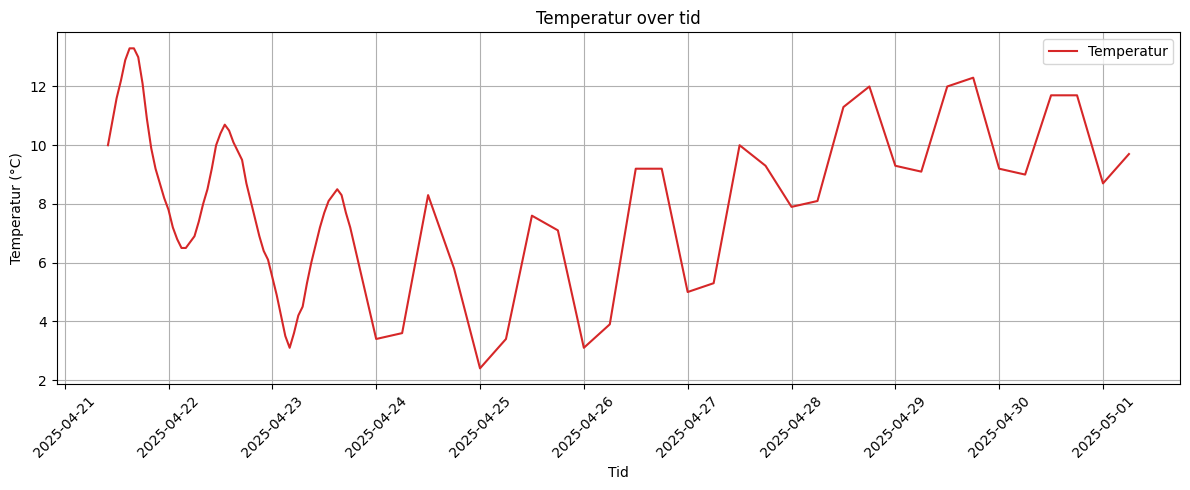


Gjennomsnittstemperaturer:
Tidspunkt
Dag:     9.467347
Natt:    6.352632
Name: temperature, dtype: float64

Differanse dag og natt: 3.11 °C


C:\Users\nicol\AppData\Local\Temp\ipykernel_38896\391160874.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=gjennomsnitt.index, y=gjennomsnitt.values, palette="coolwarm")


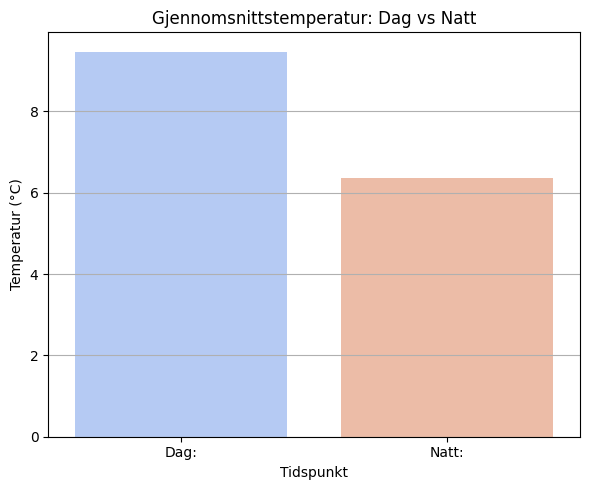

In [ ]:
"""Oppgave 5 Visualisering"""

def temp_over_tid_plot(formatert_df):
    """Lager en linjegraf av temperaturen over tid"""
    plt.figure(figsize=(12, 5))
    plt.plot(formatert_df["time"], formatert_df["temperature"], color="tab:red", label="Temperatur")
    plt.title("Temperatur over tid")
    plt.xlabel("Tid")
    plt.ylabel("Temperatur (°C)")
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

temp_over_tid_plot(formatert_df)

#Er ikke fornøy med denne grafen, tenker å spørre om hjelp for å finne/lage en graf som bedre viser natt/dag temperaturene
def dag_vs_natt_plot(formatert_df):
    """Lager en søylediagram av gjennomsnittstemperatur for dag og natt"""
    gjennomsnitt = analyser_dagstemperatur(formatert_df) #Bruker funksjonen fra oppgave 4

    plt.figure(figsize=(6, 5))
    sns.barplot(x=gjennomsnitt.index, y=gjennomsnitt.values, palette="coolwarm")
    plt.title("Gjennomsnittstemperatur: Dag vs Natt")
    plt.ylabel("Temperatur (°C)")
    plt.xlabel("Tidspunkt")
    plt.grid(axis="y")
    plt.tight_layout()
    plt.show()

dag_vs_natt_plot(formatert_df)